# RIEML DCC MODEL GRU to 405
> Created July. 2025 <br>
> Nikhil Bisht<br>

First pass sequence to GRU and then output of the sequence to 405 to predict output

# Definitions

In [1]:
# standard system modules
import os, sys
import h5py 
import argparse
# standard module for tabular data
import pandas as pd
import json

# standard module for array manipulation
import numpy as np
from itertools import permutations

# standard statistical module
import scipy.stats as st
from scipy import linalg
from scipy.stats import ks_2samp
import skimage as ski

# standard module for high-quality plots
from PIL import Image
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
mp.rcParams.update(mp.rcParamsDefault)
%matplotlib inline

# to plot pixelized images
import imageio.v3 as im

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tables
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image

from tqdm import tqdm
import random
import time
import plot
import datetime

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

DATAFILE  = '/data/cb1/nbisht/anvil_scratch/projects/rieml/tubes_take8_time.h5'
MODELFILE = 'nnmodel.dict'

TEST_PERCENTAGE = 0.2

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Available device: {str(DEVICE):4s}')

idd = 405
what = "405"
testnum=idd

Available device: cpu 


# Functions

In [2]:
def init_weights_constant(m):
    if isinstance(m, nn.Linear):
        #nn.init.constant_(m.weight, 0.5)
        nn.init.constant_(m.bias, 0.1)

def thisnet():
    hidden_dims_dcc = 256,
    conv_channels_dcc = 32
    model = DCC_NNet(hidden_dims = hidden_dims_dcc, conv_channels = conv_channels_dcc)
    return model

def train(model,data,parameters, validatedata, validateparams):
    epochs = 240000
    lr = 1e-3
    batch_size=3
    w_d = 0.01
    trainer(model,data,parameters,validatedata,validateparams,epochs=epochs,lr=lr,batch_size=batch_size, weight_decay = w_d)


def trainer(model, x_train ,y_train, x_validate, y_validate, epochs=1, lr=1e-3, batch_size=10, test_num=0, weight_decay=0.01):
    optimizer = optim.AdamW( model.parameters(), lr=lr,weight_decay =weight_decay )
    from torch.optim.lr_scheduler import CyclicLR
    scheduler = CyclicLR(
            optimizer,
            base_lr=1e-7,
            max_lr=1e-3,
            step_size_up=30000,
            mode='triangular',   # or 'triangular2', 'exp_range'
            cycle_momentum=False # if you use Adam, turn this off
    )
    losses=[]
    a = torch.arange(x_train.shape[0])
    seed = 8675309
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    t0 = time.time()
    minlist=[];meanlist=[];maxlist=[];stdlist=[]
    for epoch in range(epochs):
        subset = torch.tensor(random.sample(list(a),batch_size))
        x_subset =  x_train[subset]
        y_subset = y_train[subset]
        optimizer.zero_grad()
        output1=model(x_subset)
        loss = model.criterion(output1, y_subset)
        loss.backward()
        optimizer.step()
        scheduler.step()
        tnow = time.time()
        tel = tnow-t0
        if (epoch>0 and epoch%100==0) or epoch==10:
            model.eval()
            validate_losses = plot.compute_losses_gru(model, x_validate, y_validate)
            model.train()

            time_per_epoch = tel/epoch
            epoch_remaining = epochs-epoch
            time_remaining_s = time_per_epoch*epoch_remaining
            eta = tnow+time_remaining_s
            etab = datetime.datetime.fromtimestamp(eta)

            if 1:
                hrs = time_remaining_s//3600
                minute = (time_remaining_s-hrs*3600)//60
                sec = (time_remaining_s - hrs*3600-minute*60)#//60
                time_remaining="%02d:%02d:%02d"%(hrs,minute,sec)
            if 1:
                eta = "%0.2d:%0.2d:%0.2d"%(etab.hour, etab.minute, int(etab.second))

            mean = validate_losses.mean()
            std = validate_losses.std()
            mmin = validate_losses.min()
            mmax = validate_losses.max()
            minlist.append(mmin)
            maxlist.append(mmax)
            meanlist.append(mean)
            stdlist.append(std)
            if epoch%5000==0 or epoch == 10:
                print("test%d %d L %0.2e LR %0.2e left %8s  eta %8s loss mean %0.2e var %0.2e min %0.2e max %0.2e"%
                    (idd,epoch,loss, optimizer.param_groups[0]['lr'],time_remaining, eta, mean, std, mmin, mmax))
    print("Run time", tel)
    plt.clf()
    plt.plot(meanlist,c='k')
    plt.plot(np.array(meanlist)+np.array(stdlist),c='b')
    plt.plot(np.array(meanlist)-np.array(stdlist),c='b')
    plt.plot(minlist,c='r')
    plt.plot(maxlist,c='r')
    plt.yscale('log')
    plt.savefig('./plots/errortime_test%d'%(idd))


class DCC_NNet(nn.Module):
    def __init__(self, output_length=1000, hidden_dims=(128, 128), conv_channels=32, characteristic=False):
        super().__init__()
        self.output_length = output_length

        # Project 6 input values to a pseudo-spatial format (3 channels)
        #self.fc1 = nn.Linear(7, 3 * output_length)
        #self.relu1 = nn.ReLU()

        # Conv block 1 (acts on the "3 x output_length" format)
        dil = 1
        kern = 5
        padding = dil*(kern-1)//2
        dil2 = 2
        padding2 = dil2*(kern-1)//2
        dil3 = 4
        padding3 = dil3*(kern-1)//2
        dil4 = 8
        padding4 = dil4*(kern-1)//2
        self.conv1 = nn.Sequential(
            nn.Conv1d(3, conv_channels, kernel_size=kern, padding=padding, dilation=dil),
            nn.ReLU(),
            nn.Conv1d(conv_channels, 3, kernel_size=kern, padding=padding, dilation=dil),
            nn.ReLU()
        )

        # FC block 2: merge spatial info
        in_dim = 3*output_length
        out_dim = 3*output_length
        layers=[]
        dims = [in_dim] + list(hidden_dims) + [out_dim]
        for i in range(len(dims)-1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            if i < len(dims) - 2:
                layers.append(nn.ReLU())
        self.fc2 = nn.Sequential(*layers)

        # Conv block 2
        dil = 1
        kern = 3
        padding = dil*(kern-1)//2
        self.conv2 = nn.Sequential(
            nn.Conv1d(3, conv_channels, kernel_size=kern, padding=padding, dilation=dil),
            nn.ReLU(),
            nn.Conv1d(conv_channels, 3, kernel_size=kern, padding=padding, dilation=dil)
        )
        dil1 = 2
        kern1 = 3
        padding1 = dil1*(kern1-1)//2
        dil2 = 2
        kern2 = 3
        padding2 = dil2*(kern2-1)//2
        dil3 = 5
        kern3 = 7
        padding3 = dil3*(kern3-1)//2
        self.conv3a = nn.Sequential(
            nn.Conv1d(3, conv_channels, kernel_size=kern1, padding=padding1, dilation=dil1),
            nn.ReLU())
        self.conv3b = nn.Sequential(
            nn.Conv1d(conv_channels, 2*conv_channels, kernel_size=kern2, padding=padding2, dilation=dil2),
            nn.ReLU())
        self.conv3e = nn.Sequential(
            nn.Conv1d(2*conv_channels, conv_channels, kernel_size=kern2, padding=padding2, dilation=dil2),
            nn.ReLU())
        self.convdone = nn.Sequential(
            nn.Conv1d(conv_channels, 3, kernel_size=kern1, padding=padding1, dilation=dil1)
        )
        self.conv1.apply(init_weights_constant)
        self.conv2.apply(init_weights_constant)
        self.conv3a.apply(init_weights_constant)
        self.conv3b.apply(init_weights_constant)
        self.conv3e.apply(init_weights_constant)
        self.convdone.apply(init_weights_constant)
        self.fc2.apply(init_weights_constant)
        #self.fc1.apply(init_weights_constant)

        self.T = nn.Parameter(torch.eye(3) + 0.01 * torch.randn(3, 3)) 

        self.mse=nn.MSELoss()
        self.log_derivative_weight = nn.Parameter(torch.tensor(0.0)) 

        embed_dim=output_length
        num_heads = 4
        self.hl = nn.HuberLoss(delta=0.2)
        self.l1 = nn.L1Loss()



    def criterion(self,guess,target, initial=None):
        L1 = self.l1(target,guess)
        return L1

    def forward(self, x):
        batch_size=x.shape[0]
        # FC1 to expand global features into spatial representation
        #x = self.fc1(x)  # (batch_size, 3*output_length)
        #x = self.relu1(x)
        #x = x.view(batch_size, 3, self.output_length)  # shape (B, 3, L)

        # Conv block 1: local patterns
        x = x + self.conv1(x)  # Residual connection

        # FC2 block: reprocess globally
        x_flat = x.view(batch_size, -1)
        x_flat = self.fc2(x_flat)
        x = x_flat.view(batch_size,3, self.output_length)

        # Conv block 2: refine locally again
        x = x + self.conv2(x)
        x1 = self.conv3a(x)
        x2 = self.conv3b(x1)
        x5 =x1+ self.conv3e(x2)
        z = x+self.convdone(x5)
    

        return z  # shape (B, 3, output_length)



# Load Images

In [3]:
from importlib import reload
import plot
reload(plot)

import tube_loader

def get_data(in_seq = 1, dilation = 1, out_seq = 1, nvalid=50, ntest=100):
    '''
    in_seq: number of input time snapshots
    dilation: how many snapshots ahead to predict
    out_seq: number of output snapshots
    '''
    seq_l = in_seq+(dilation-1)+out_seq
    rieml_data, parameters= tube_loader.read_all_parameters(DATAFILE)
    reshaped_data = rieml_data.reshape(3000,11,3,1000)
    sequenced_data = np.array([]).reshape(0,2,3,1000)
    for i in range(11-seq_l+1):
        time_indices_in = [j for j in range(i,i+in_seq)]
        time_indices_out = [j for j in range(i+in_seq+dilation-1,i+in_seq+dilation-1+out_seq)]
        time_indices_in.extend(time_indices_out)
        time_indices = time_indices_in
        print(time_indices)
        sequenced_data = np.concatenate((sequenced_data,reshaped_data[:,time_indices,:,:]), axis=0)
    #shuffle dataset
    shuffled_indices = torch.randperm(sequenced_data.shape[0])
    sequenced_data_shuffled = torch.index_select(torch.from_numpy(sequenced_data), dim=0, index=shuffled_indices)
    len_seq = sequenced_data_shuffled.shape[0]
    ntrain = len_seq-nvalid-ntest
    # Split the tensor
    train_dataset, test_dataset, validation_dataset = torch.split(sequenced_data_shuffled.float(), [ntrain,ntest,nvalid], dim=0)
    X = {'train': train_dataset[:,0,:,:], 'test': test_dataset[:,0,:,:], 'validate': validation_dataset[:,0,:,:]}
    y = {'train': train_dataset[:,1,:,:], 'test': test_dataset[:,1,:,:], 'validate': validation_dataset[:,1,:,:]}
    return X,y

rieml_data_seq, parameters_seq = get_data(in_seq = 1, dilation = 4, out_seq = 1, nvalid=50, ntest=100)

[0, 4]
[1, 5]
[2, 6]
[3, 7]
[4, 8]
[5, 9]
[6, 10]


# Train Model

Model 405 with 1,553,867 parameters
test405 10 L 6.58e-01 LR 4.67e-07 left 01:39:38  eta 19:29:27 loss mean 6.31e-01 var 1.72e-01 min 3.70e-01 max 1.18e+00
test405 5000 L 5.28e-02 LR 1.67e-04 left 01:20:35  eta 19:12:07 loss mean 5.96e-02 var 2.60e-02 min 3.75e-02 max 1.79e-01
test405 10000 L 3.68e-02 LR 3.33e-04 left 01:18:55  eta 19:12:10 loss mean 4.12e-02 var 2.21e-02 min 2.30e-02 max 1.60e-01
test405 15000 L 3.42e-02 LR 5.00e-04 left 01:17:11  eta 19:12:08 loss mean 3.47e-02 var 1.89e-02 min 1.40e-02 max 1.44e-01
test405 20000 L 1.84e-02 LR 6.67e-04 left 01:15:26  eta 19:12:07 loss mean 3.08e-02 var 1.94e-02 min 1.16e-02 max 1.42e-01
test405 25000 L 2.93e-02 LR 8.33e-04 left 01:13:44  eta 19:12:07 loss mean 3.60e-02 var 1.83e-02 min 1.65e-02 max 1.31e-01
test405 30000 L 3.86e-02 LR 1.00e-03 left 01:12:01  eta 19:12:08 loss mean 3.57e-02 var 1.75e-02 min 2.13e-02 max 1.28e-01
test405 35000 L 3.17e-02 LR 8.33e-04 left 01:10:19  eta 19:12:09 loss mean 2.86e-02 var 1.54e-02 min 1.36e-

FileNotFoundError: [Errno 2] No such file or directory: './plots/errortime_test405.png'

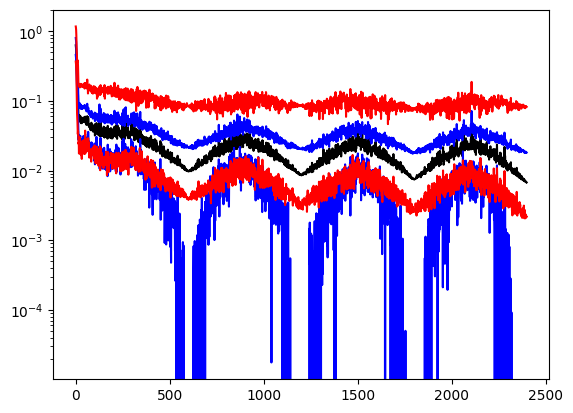

In [4]:
new_model = 1
load_model = 0
train_model = 1

if new_model:
    model = thisnet()
    nparam = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model {testnum:d} with {nparam:,d} parameters")

if load_model:
    model.load_state_dict(torch.load("models/test%d.pth"%idd))

total_time='no'
if train_model:
    t0 = time.time()

    train(model,rieml_data_seq['train'],parameters_seq['train'], rieml_data_seq['validate'],parameters_seq['validate'])

    t1 = time.time() - t0
    hrs = t1//3600
    minute = (t1-hrs*3600)//60
    sec = (t1 - hrs*3600-minute*60)#//60
    total_time="%02d:%02d:%02d"%(hrs,minute,sec)

if not load_model:
    nparam = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model test{testnum:d} with {nparam:,d} parameters elapsed {total_time:s}")
    oname = "models/test%d.pth"%testnum
    torch.save(model.state_dict(), oname)
    print("model saved ",oname)


In [5]:
if not load_model:
    nparam = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model test{testnum:d} with {nparam:,d} parameters elapsed {total_time:s}")
    oname = "models/test%d.pth"%testnum
    torch.save(model.state_dict(), oname)
    print("model saved ",oname)

Model test405 with 1,553,867 parameters elapsed no
model saved  models/test405.pth


losses
plot


RuntimeError: shape '[1, 3]' is invalid for input of size 3000

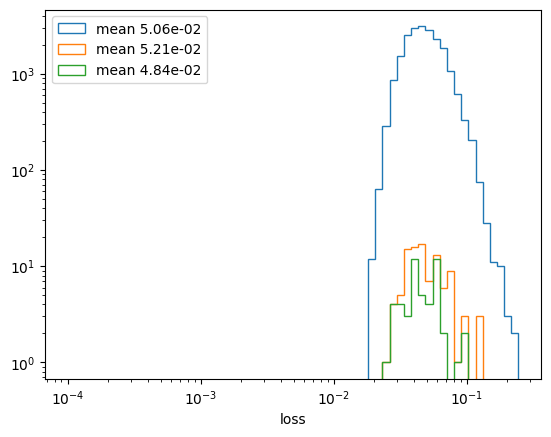

In [ ]:
load_model = 1
skip_train_plot = 1  #skip every nth element in array for high parameter models, 1 for low parameter model that don't cause kernel crash
if load_model:
    model.load_state_dict(torch.load("models/test%d.pth"%idd))
if 1:
    print('losses')
    loss_train = torch.from_numpy(plot.compute_losses_gru(model, rieml_data_seq['train'][::skip_train_plot],parameters_seq['train'][::skip_train_plot]))
    loss_test = torch.from_numpy(plot.compute_losses_gru(model, rieml_data_seq['test'],parameters_seq['test']))
    loss_validate = torch.from_numpy(plot.compute_losses_gru(model, rieml_data_seq['validate'],parameters_seq['validate']))
    args_train = torch.argsort(loss_train)
    args_test = torch.argsort(loss_test)
    #args_validate = torch.argsort(loss_validate)
if 1:
    print('plot')
    plot.plot_hist(loss_train,loss_test,loss_validate,idd)

    zzz=plot.test_plot_gru(rieml_data_seq['test'][args_test[:5]], parameters_seq['test'][args_test[:5]], model, fname="test%d_test_best"%testnum)
    zzz=plot.test_plot_gru(rieml_data_seq['test'][args_test[-5:]], parameters_seq['test'][args_test[-5:]], model, fname="test%d_test_worst"%testnum)
    zzz=plot.test_plot_gru(rieml_data_seq['train'][::skip_train_plot][args_train[:5]], parameters_seq['train'][::skip_train_plot][args_train[:5]], model, fname="test%d_train_best"%testnum)
    zzz=plot.test_plot_gru(rieml_data_seq['train'][::skip_train_plot][args_train[-5:]], parameters_seq['train'][::skip_train_plot][args_train[-5:]], model, fname="test%d_train_worst"%testnum)
    zzz=plot.test_plot_gru(rieml_data_seq['validate'], parameters_seq['validate'], model, fname="test%04d_avalidate"%testnum)
